In [1]:
using Pkg
Pkg.add("CurveFit")
Pkg.add("Plots")
Pkg.add("PyPlot")
using CurveFit
using Plots
pyplot()

   Updating registry at `~/.julia/registries/General`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`


Plots.PyPlotBackend()

## 反射率を求める
### 垂直入射での反射率は
$$
R = \biggl(\frac{1-n_{1}}{1+n_{1}}\biggr)^{2}
$$
### 斜入射の反射率
実効屈折率$\eta$を用いて計算する
$$
\eta = 
    \begin{cases}
         -n\cos\theta \quad \text{s-polarized} \\
         \frac{n}{\cos\theta} \qquad  \  \text{p-polarized} \\
    \end{cases}
$$
実効屈折率を用いて
$$
R=\biggl|\frac{\eta_{0}-\eta_{1}}{\eta_{0}+\eta_{1}}\biggr|^{2}
$$

In [21]:
function reflectance(n1; theta=0)
    # snellの法則
    phi = asin(sin(theta)/n1)
    # s偏光
    eta0s = -cos(theta)
    eta1s = -n1*cos(phi)
    rs = (abs((eta0s-eta1s)/(eta0s+eta1s)))^2
    # p偏光
    eta0p = 1/cos(theta)
    eta1p = n1/cos(phi)
    rp = (abs((eta0p-eta1p)/(eta0p+eta1p)))^2
    return (rs+rp)/2
end

reflectance (generic function with 3 methods)

## 裏面反射を含める  
<img src="裏面反射を含む反射.png">

媒質$i$から媒質$j$へ入る際の反射および透過をそれぞれ$R_{ij}$、$T_{ij}$とすると
$$
\begin{align}
R_{total}  &= R_{01}+
              T_{01}R_{12}T_{10}+
              T_{01}R_{12}R_{10}R_{12}T_{10}+
              T_{01}R_{12}R_{10}R_{12}R_{10}R_{12}T_{10}+\cdots \\
           &= R_{01}+\sum_{n}^{\infty}T_{01}R_{12}T_{10}(R_{10}R_{12})^{n-1} \\
           &= R_{01}+\frac{T_{01}R_{12}T_{10}}{1-R_{10}R_{12}}
\end{align}              
$$
ここで
$$
T_{ij} = 1-R_{ij}　\\
R_{ij} = R_{ji}
$$
なので、
$$
\begin{align}
R_{total}  &= R_{01}+\frac{(1-R_{01})R_{12}(1-R_{10})}{1-R_{10}R_{12}} \\
           &= R_{01}+\frac{(1-R_{01})^2R_{12}}{1-R_{01}R_{12}} \\
           &= \frac{R_{01}-R_{01}^2R_{12}+R_{12}-2R_{01}R_{12}+R_{01}^2R_{12}}{1-R_{01}R_{12}} \\
           &= \frac{R_{01}+R_{12}-2R_{01}R_{12}}{1-R_{01}R_{12}}
\end{align}
$$
## 吸収を考慮に入れる
吸収係数$\alpha$と消衰係数$\kappa$の関係は
$$
\alpha = \frac{4\pi\kappa}{\lambda}
$$
長さ$x$進むと光の強度は
$$
I = I_{0}\exp(-\alpha x)
$$
角度$\phi$で入射した光が裏面で反射して戻ってくるまでの光路長は
$$
x = \frac{2t}{\cos\phi}
$$
よって１回の反射での光路長による吸収は
$$
D = \exp\biggl(-\frac{8t\pi\kappa}{\lambda\cos\phi}\biggr)
$$
反射の式に入れると
$$
\begin{align}
R_{total}  &= R_{01}+
              T_{01}R_{12}T_{10}D+
              T_{01}R_{12}R_{10}R_{12}T_{10}D^{2}+
              T_{01}R_{12}R_{10}R_{12}R_{10}R_{12}T_{10}D^{3}+\cdots \\
           &= R_{01}+\sum_{n}^{\infty}T_{01}R_{12}T_{10}D(R_{10}R_{12}D)^{n-1} \\
           &= R_{01}+\frac{T_{01}R_{12}T_{10}D}{1-R_{10}R_{12}D} \\
           &= R_{01}+\frac{(1-R_{01})^2R_{12}D}{1-R_{01}R_{12}D} \\
           &= \frac{R_{01}+R_{12}D-2R_{01}R_{12}D}{1-R_{01}R_{12}D}
\end{align}              
$$

In [22]:
function reflectance(wl,n1; theta=0,t=1)
    # snellの法則
    phi = asin(sin(theta)/n1)
    # s偏光
    eta0s = -cos(theta)
    eta1s = -n1*cos(phi)
    r01s = (abs((eta0s-eta1s)/(eta0s+eta1s)))^2
    # p偏光
    eta0p = 1/cos(theta)
    eta1p = n1/cos(phi)
    r01p = (abs((eta0p-eta1p)/(eta0p+eta1p)))^2
    # 減衰量
    d = abs(exp(-8pi*t*imag(n1)/(wl*cos(phi))))
    # 反射
    rs = (r01s+r01s*d-2*r01s^2*d)/(1-r01s^2*d)
    rp = (r01p+r01p*d-2*r01p^2*d)/(1-r01p^2*d)
    return (rs+rp)/2
end

reflectance (generic function with 3 methods)

In [4]:
function reflectance(wl,n0,n1,n2; theta=0,t=1)
    # snellの法則
    phi1 = asin(sin(theta)*n0/n1)
    phi2 = asin(sin(theta)*n0/n2)
    # s偏光
    eta0s = -n0*cos(theta)
    eta1s = -n1*cos(phi1)
    eta2s = -n2*cos(phi2)
    r01s = (abs((eta0s-eta1s)/(eta0s+eta1s)))^2
    r12s = (abs((eta1s-eta2s)/(eta1s+eta2s)))^2
    # p偏光
    eta0p = n0/cos(theta)
    eta1p = n1/cos(phi1)
    eta2p = n2/cos(phi2)
    r01p = (abs((eta0p-eta1p)/(eta0p+eta1p)))^2
    r12p = (abs((eta1p-eta2p)/(eta1p+eta2p)))^2
    # 減衰量
    d = abs(exp(-8pi*t*imag(n1)/(wl*cos(phi1))))
    # 反射
    rs = (r01s+r12s*d-2*r01s*r12s*d)/(1-r01s*r12s*d)
    rp = (r01p+r12p*d-2*r01p*r12p*d)/(1-r01p*r12p*d)
    return (rs+rp)/2
end

reflectance (generic function with 3 methods)

## 透過について考える
$$
T_{ij} = \biggl|\frac{n_{i}\cos\theta_{i}}{n_{j}\cos\theta_{j}}\biggr|\cdot\frac{4\Re(\eta_{i})\Re(\eta_{j})}{(\eta_{i}+\eta_{j})^{2}}
$$
を用いて
$$
\begin{align}
T_{total}  &= T_{01}T_{12}+
              T_{01}R_{12}R_{10}T_{12}+
              T_{01}R_{12}R_{10}R_{12}R_{10}T_{12}+
              T_{01}R_{12}R_{10}R_{12}R_{10}R_{12}R_{10}T_{12}+\cdots \\
           &= \sum_{n}^{\infty}T_{01}T_{12}(R_{10}R_{12})^{n-1} \\
           &= \frac{T_{01}T_{12}}{1-R_{10}R_{12}}
\end{align}              
$$
吸収を考えると
$$
\begin{align}
T_{total}  &= \sum_{n}^{\infty}T_{01}T_{12}D^{1/2}(R_{10}R_{12}D)^{n-1} \\
           &= \frac{T_{01}T_{12}D^{1/2}}{1-R_{10}R_{12}D}
\end{align}              
$$


In [5]:
function transmittance(wl,n1; theta=0,t=1)
    # snellの法則
    phi = asin(sin(theta)/n1)
    # s偏光
    eta0s = -cos(theta)
    eta1s = -n1*cos(phi)
    r01s = (abs((eta0s-eta1s)/(eta0s+eta1s)))^2
    t010s = 16*real(eta0s)^2*real(eta1s)^2/abs((eta0s+eta1s)*conj(eta0s+eta1s))^2
    # p偏光
    eta0p = 1/cos(theta)
    eta1p = n1/cos(phi)
    r01p = (abs((eta0p-eta1p)/(eta0p+eta1p)))^2
    t010p = 16*real(eta0p)^2*real(eta1p)^2/abs((eta0p+eta1p)*conj(eta0p+eta1p))^2
    # 減衰量
    d = abs(exp(-8pi*t*imag(n1)/(wl*cos(phi))))
    # 透過
    ts = t010s*sqrt(d)/(1-r01s^2*d)
    tp = t010p*sqrt(d)/(1-r01p^2*d)
    @show 
    return (ts+tp)/2
end

transmittance (generic function with 1 method)

In [6]:
function transmittance(wl,n0,n1,n2; theta=0,t=1)
    # snellの法則
    phi1 = asin(sin(theta)*n0/n1)
    phi2 = asin(sin(theta)*n0/n2)
    # s偏光
    eta0s = -n0*cos(theta)
    eta1s = -n1*cos(phi1)
    eta2s = -n2*cos(phi2)
    r01s = (abs((eta0s-eta1s)/(eta0s+eta1s)))^2
    r12s = (abs((eta1s-eta2s)/(eta1s+eta2s)))^2
    t012s = abs(n0*cos(theta)/(n2*cos(phi2)))*16*real(eta0s)*real(eta1s)^2*real(eta2s)/(abs((eta0s+eta1s)*conj(eta0s+eta1s))*abs((eta1s+eta2s)*conj(eta1s+eta2s)))
    # p偏光
    eta0p = n0/cos(theta)
    eta1p = n1/cos(phi1)
    eta2p = n2/cos(phi2)
    r01p = (abs((eta0p-eta1p)/(eta0p+eta1p)))^2
    r12p = (abs((eta1p-eta2p)/(eta1p+eta2p)))^2
    t012p = abs(n0*cos(theta)/(n2*cos(phi2)))*16*real(eta0p)*real(eta1p)^2*real(eta2p)/(abs((eta0p+eta1p)*conj(eta0p+eta1p))*abs((eta1p+eta2p)*conj(eta1p+eta2p)))
    # 減衰量
    d = abs(exp(-8pi*t*imag(n1)/(wl*cos(phi1))))
    # 反射
    ts = t012s*sqrt(d)/(1-r01s*r12s*d)
    tp = t012p*sqrt(d)/(1-r01p*r12p*d)
    return (ts+tp)/2
end

transmittance (generic function with 2 methods)

## Cauchyの式
$$
n(\lambda) = A + \frac{B}{\lambda^{2}} + \frac{C}{\lambda^{4}}
$$

In [7]:
function cauchy(lam; a=1.0, b=0, c=0)
    return a + b/lam^2 + c/lam^4
end

cauchy (generic function with 1 method)

In [8]:
function fit_cauchy(wl,r;a =1.5,b=0.01,c=0,eps=1e-7,iters=1000)
    func(xs,param) = reflectance(cauchy(xs[1],a=param[1],b=param[2],c=param[3]))-xs[2]
    return nonlinear_fit([wl r],func,[a,b,c],eps,iters)
end

fit_cauchy (generic function with 1 method)

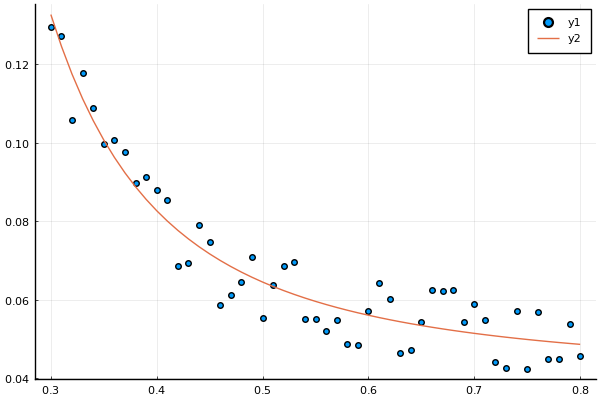

In [9]:
x = 0.3:0.01:0.8
y = reflectance.(cauchy.(x, a=1.543, b=0.02, c= 0.003)) + (rand(length(x)) .-0.5)*0.02
plot(x, y, st=:scatter)
param, converged, iter  = fit_cauchy(x,y)
plot!(x,reflectance.(cauchy.(x, a=param[1], b=param[2], c= param[3])))

## 裏面反射の有無で吸収を計算する
基板の両側が同一媒質（空気）であるとする。
裏面反射を含む反射を$R$、含まない反射を$R_{B}$とすれば
$$
R = R_{B}+\frac{(1-R_{B})^2R_{B}D}{1-R_{B}^{2}D}            
$$
$D$について解くと
$$
D = \frac{R-R_{B}}{(RR_{B}-2RR_{B}+1)R_{B}}
$$


## Cauchyモデル（吸収あり）

In [10]:
function cauchy(lam; a=1.0, b=0, c=0, k=0, expo=1.5)
    return complex(a + b/lam^2 + c/lam^4, k*exp(expo/lam))
end

cauchy (generic function with 1 method)

In [11]:
wl = 0.3:0.05:0.8

0.3:0.05:0.8

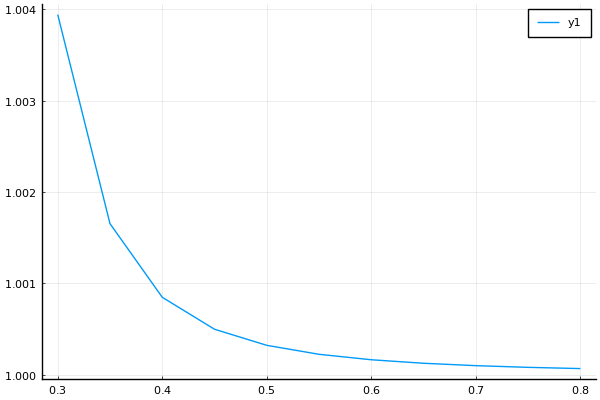

In [20]:
plot(wl,exp.(4*pi\imag.(cauchy.(wl,a=1.5,b=0.08,c=1e-4,k=1e-4)) ./wl))

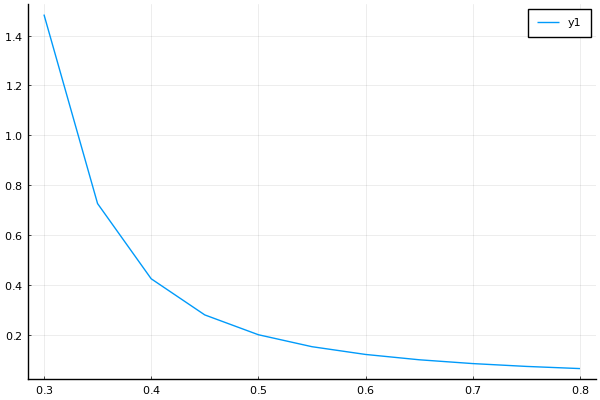

In [13]:
plot(wl,1e-2*exp.(1.5./wl))

In [14]:
t=100
phi=5*π/180
exp.(-8*π*t*0.001./wl/cos(phi))

11-element Array{Float64,1}:
 0.0002227230680057324
 0.0007404794815934165
 0.0018231562906258448
 0.0036743185068401647
 0.0064366385240999975
 0.01018291051890681
 0.014923909273569456
 0.020623063044005928
 0.02721175263729656
 0.034602388680336015
 0.042698434287756326